In [1]:
%pylab inline --no-import-all
from sympy import Symbol, symbols, solve, lambdify
#import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import matplotlib.pyplot as plt

In [3]:
#observables
(n11, n12, n21, n22) =  symbols('n11 n12 n21 n22')
#parameters
(s1, s2, b1, b2, mu) =  symbols('s1 s2 b1 b2 mu')
#helpers
(n1, n2, nu11, nu12, n21, nu22) =  symbols('n1 n2 nu11 nu12 nu21 n22')
#estimators
(s1hat, s2hat, muhat) = symbols('s1hat s2hat muhat')

In [4]:
#first run
nu11 = s1hat + b1
nu12 = s2hat + b2
#second run
nu21 = muhat*s1hat+b1
nu22 = muhat*s2hat+b2

In [5]:
#first run
shatSubs = [(key, val) for key,val in solve([n11-nu11, n12-nu12], s1hat, s2hat).iteritems()]
moreSubs = shatSubs+[(n11,10),(n12,10),(n21,10),(n22,10),(b1,5),(b2,5)]
s1hat.subs(moreSubs), s2hat.subs(moreSubs)

(5, 5)

In [6]:
#second run
[expr1, expr2] = solve( s1hat+s2hat - n21*s1hat/nu21 - n22*s2hat/nu22, muhat)

In [7]:
expr1.subs(moreSubs),expr2.subs(moreSubs)

(-1, 1)

In [8]:
muhatFunc = lambdify((n11,n12,n21,n22,b1,b2), expr2.subs(shatSubs), "numpy")
muhatFunc(10,10,10,10,5,5)

1.0

In [28]:
nExp = 1000
truth=[(b1,5),(b2,5),(s1hat,5),(s2hat,5),(muhat,1)]
n11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
n21_expts = np.random.poisson(nu21.subs(truth),nExp)
n22_expts = np.random.poisson(nu22.subs(truth),nExp)
muhat_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))

In [30]:
muhat_expts = filter(lambda x: x<1e6, muhat_expts)

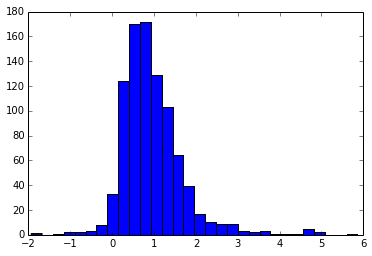

In [35]:
contents, edges, patches = plt.hist(muhat_expts,bins=30)